<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

In [1]:
import pandas as pd

df = pd.read_csv('./Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv')

print(df.shape)

df.head()

(28332, 24)


,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht..."
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht..."
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht..."


In [2]:
df['name'].value_counts()

AmazonBasics AAA Performance Alkaline Batteries (36 Count)                                                                                                8343
AmazonBasics AA Performance Alkaline Batteries (48 Count) - Packaging May Vary                                                                            3728
Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Tangerine - with Special Offers                                                                         2443
All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Black                                                                     2370
Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Pink Kid-Proof Case                                                                                    1676
Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Blue Kid-Proof Case                                                                                    1425
Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16

In [3]:
df['brand'].value_counts()

Amazon          16153
Amazonbasics    12169
AmazonBasics       10
Name: brand, dtype: int64

In [5]:
df['brand'] = df['brand'].apply(lambda x: x.lower())
df['brand'].value_counts()

amazon          16153
amazonbasics    12179
Name: brand, dtype: int64

In [10]:
# custom pre-processing

import spacy

nlp = spacy.load('en_core_web_lg')

In [12]:
def get_lemmas(text):
    lemmas = []
    doc = nlp(text)
    
    for token in doc:
        if ((token.is_stop is False) and (token.is_punct is False) and (token.pos_ is not 'PRON')):
            lemmas.append(token.lemma_)
            
    return lemmas

In [53]:
df['reviews.lemmas'] = df['reviews.text'].apply(get_lemmas)

df.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs,reviews.lemmas
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht...","[order, 3, item, bad, quality, miss, backup, s..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht...","[Bulk, expensive, way, product, like]"
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht...","[Duracell, price, happy]"
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht...","[work, brand, battery, well, price]"
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht...","[battery, long, last, price, great]"


In [13]:
def stream_from_df(column):
    for row in column:
        lemmas = get_lemmas(str(row))
        yield lemmas

In [54]:
streaming_data = stream_from_df(df['reviews.lemmas'])

In [55]:
from gensim import corpora

id2word = corpora.Dictionary(streaming_data)

In [56]:
len(id2word.keys())

9098

In [17]:
corpus = [id2word.doc2bow(text) for text in stream_from_df(df['reviews.text'])]

In [25]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore

def compute_coherence_values(dictionary, corpus, column, limit, start=2, step=3, passes=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    --> column <--: Dataframe column to use (changed by David Nagy)
    limit : Max num of topics
    passes: the number of times the entire lda model & coherence values are calculated

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    
    tokens = list(stream_from_df(column))
    
    for iter_ in range(passes):
        for num_topics in range(start, limit, step):
            stream = stream_from_df(column)
            model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=4)
            coherencemodel = CoherenceModel(model=model,dictionary=dictionary,corpus=corpus, coherence='u_mass')
            coherence_values.append({'pass': iter_, 
                                     'num_topics': num_topics, 
                                     'coherence_score': coherencemodel.get_coherence()
                                    })

    return coherence_values

In [23]:
# code from Trevor Clack to silence warnings

import warnings # remove deprecation warnings for each iteration
with warnings.catch_warnings():
  warnings.filterwarnings("ignore",category=DeprecationWarning)

In [26]:
coherence_values = compute_coherence_values(dictionary=id2word,
                                            corpus=corpus,
                                            column=df['reviews.text'],
                                            start=2,
                                            limit=40,
                                            step=6,
                                            passes=10 # setting passes low so it takes less time
                                           )

topic_coherence = pd.DataFrame.from_records(coherence_values)

topic_coherence.head()

,coherence_score,num_topics,pass
0,-2.270306,2,0
1,-2.451359,8,0
2,-2.453716,14,0
3,-2.577729,20,0
4,-2.589655,26,0


C:\Anaconda3\envs\Unit4_Sprint1\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


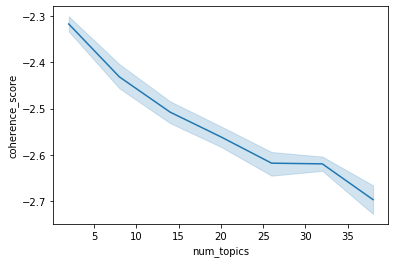

In [27]:
import seaborn as sns

ax = sns.lineplot(x='num_topics', y='coherence_score', data=topic_coherence)

# They're all well below 0 unfortunately, which suggests that I should be including additional stop words.
# Maybe I'll do that at the end if I have time. In the meantime, I'll just use 5 topics.

In [57]:
id2word.filter_extremes(no_below=0.1, no_above=0.9)

print(len(id2word.keys()))

corpus = [id2word.doc2bow(df['reviews.text']) for text in stream_from_df(df['reviews.text'])]

corpus[0][:10]

9098


[(11, 1),
 (14, 1),
 (19, 1),
 (21, 49),
 (32, 60),
 (39, 1),
 (44, 5),
 (82, 1),
 (148, 1),
 (164, 7)]

In [58]:
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=1000,
                   num_topics=5,
                   passes=10,
                   workers=8)

lda.print_topics()

[(0,
  '0.163*"good" + 0.153*"great" + 0.144*"Good" + 0.099*"ok" + 0.086*"Excellent" + 0.045*"excellent" + 0.032*"Nice" + 0.021*"Perfect" + 0.021*"nice" + 0.018*"awesome"'),
 (1,
  '0.217*"good" + 0.131*"great" + 0.119*"Good" + 0.102*"ok" + 0.089*"Excellent" + 0.035*"excellent" + 0.028*"Nice" + 0.022*"Perfect" + 0.020*"nice" + 0.019*"Batteries"'),
 (2,
  '0.211*"good" + 0.160*"great" + 0.129*"Good" + 0.104*"ok" + 0.078*"Excellent" + 0.032*"Nice" + 0.029*"excellent" + 0.021*"nice" + 0.020*"awesome" + 0.015*"Perfect"'),
 (3,
  '0.177*"good" + 0.142*"great" + 0.129*"Good" + 0.109*"Excellent" + 0.098*"ok" + 0.033*"excellent" + 0.030*"Nice" + 0.028*"nice" + 0.018*"awesome" + 0.016*"Batteries"'),
 (4,
  '0.178*"great" + 0.164*"good" + 0.136*"Good" + 0.111*"ok" + 0.076*"Excellent" + 0.035*"Nice" + 0.030*"excellent" + 0.021*"awesome" + 0.021*"Perfect" + 0.020*"nice"')]

In [60]:
STOP_WORDS = nlp.Defaults.stop_words.union(['good', 'great', 'ok', 'excellent',
                                            'nice', 'perfect', 'awesome'])

def get_lemmas(text):
    lemmas = []
    doc = nlp(text)
    
    for token in doc:
        if ((token.text.lower() not in STOP_WORDS) and (token.is_punct is False) and (token.pos_ is not 'PRON')):
            lemmas.append(token.lemma_)
            
    return lemmas

In [61]:
df['reviews.lemmas'] = df['reviews.text'].apply(get_lemmas)

In [62]:
streaming_data = stream_from_df(df['reviews.lemmas'])

In [63]:
id2word = corpora.Dictionary(streaming_data)

len(id2word.keys())

9087

In [64]:
id2word.filter_extremes(no_below=0.1, no_above=0.9)

print(len(id2word.keys()))

corpus = [id2word.doc2bow(df['reviews.text']) for text in stream_from_df(df['reviews.text'])]

corpus[0][:10]

9087


[(11, 1),
 (14, 1),
 (19, 1),
 (37, 1),
 (79, 1),
 (145, 1),
 (174, 1),
 (210, 60),
 (248, 1),
 (252, 4)]

In [65]:
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=1000,
                   num_topics=5,
                   passes=10,
                   workers=8)

lda.print_topics()

[(0,
  '0.001*"good" + 0.000*"Batteries" + 0.000*"fine" + 0.000*"A++++" + 0.000*"super" + 0.000*"aaa+++" + 0.000*"reliable" + 0.000*"GoodGood" + 0.000*"Cheap" + 0.000*"ty"'),
 (1,
  '0.001*"good" + 0.000*"fine" + 0.000*"Batteries" + 0.000*"A++++" + 0.000*"terrific" + 0.000*"super" + 0.000*"ty" + 0.000*"aaa+++" + 0.000*"A++" + 0.000*"GoodGood"'),
 (2,
  '0.492*"good" + 0.041*"Batteries" + 0.033*"fine" + 0.033*"A++++" + 0.016*"Cheap" + 0.016*"GoodGood" + 0.016*"A++" + 0.016*"reliable" + 0.016*"terrific" + 0.016*"AOK"'),
 (3,
  '0.081*"good" + 0.009*"Batteries" + 0.007*"A++++" + 0.004*"fine" + 0.004*"AOK" + 0.004*"super" + 0.003*"aaa+++" + 0.003*"reliable" + 0.003*"terrific" + 0.003*"ty"'),
 (4,
  '0.001*"good" + 0.000*"fine" + 0.000*"A++++" + 0.000*"Batteries" + 0.000*"aaa+++" + 0.000*"super" + 0.000*"AOK" + 0.000*"terrific" + 0.000*"A++" + 0.000*"ty"')]

In [66]:
import re

words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]

In [67]:
topics = [' '.join(t[0:5]) for t in words]

In [68]:
topics

['good Batteries fine A++++ super',
 'good fine Batteries A++++ terrific',
 'good Batteries fine A++++ Cheap',
 'good Batteries A++++ fine AOK',
 'good fine A++++ Batteries aaa+++']

In [69]:
distro = [lda[d] for d in corpus]

In [70]:
def update(doc):
        d_dist = {k:0 for k in range(0,5)}
        for t in doc:
            d_dist[t[0]] = t[1]
        return d_dist
    
new_distro = [update(d) for d in distro]

In [71]:
new_distro

[{0: 0, 1: 0, 2: 0.99348867, 3: 0, 4: 0},
 {0: 0, 1: 0, 2: 0.99348867, 3: 0, 4: 0},
 {0: 0, 1: 0, 2: 0.9934882, 3: 0, 4: 0},
 {0: 0, 1: 0, 2: 0.99348825, 3: 0, 4: 0},
 {0: 0, 1: 0, 2: 0.99348867, 3: 0, 4: 0},
 {0: 0, 1: 0, 2: 0.99348867, 3: 0, 4: 0},
 {0: 0, 1: 0, 2: 0.9934882, 3: 0, 4: 0},
 {0: 0, 1: 0, 2: 0.99348825, 3: 0, 4: 0},
 {0: 0, 1: 0, 2: 0.99348855, 3: 0, 4: 0},
 {0: 0, 1: 0, 2: 0.9934885, 3: 0, 4: 0},
 {0: 0, 1: 0, 2: 0.99348867, 3: 0, 4: 0},
 {0: 0, 1: 0, 2: 0.99348855, 3: 0, 4: 0},
 {0: 0, 1: 0, 2: 0.9934882, 3: 0, 4: 0},
 {0: 0, 1: 0, 2: 0.99348825, 3: 0, 4: 0},
 {0: 0, 1: 0, 2: 0.99348855, 3: 0, 4: 0},
 {0: 0, 1: 0, 2: 0.9934884, 3: 0, 4: 0},
 {0: 0, 1: 0, 2: 0.99348843, 3: 0, 4: 0},
 {0: 0, 1: 0, 2: 0.99348867, 3: 0, 4: 0},
 {0: 0, 1: 0, 2: 0.9934882, 3: 0, 4: 0},
 {0: 0, 1: 0, 2: 0.9934882, 3: 0, 4: 0},
 {0: 0, 1: 0, 2: 0.9934885, 3: 0, 4: 0},
 {0: 0, 1: 0, 2: 0.99348855, 3: 0, 4: 0},
 {0: 0, 1: 0, 2: 0.9934884, 3: 0, 4: 0},
 {0: 0, 1: 0, 2: 0.99348843, 3: 0, 4: 0},
 

In [72]:
df2 = pd.DataFrame.from_records(new_distro, index=df['name'])
df2.columns = topics
df2.head()

,good Batteries fine A++++ super,good fine Batteries A++++ terrific,good Batteries fine A++++ Cheap,good Batteries A++++ fine AOK,good fine A++++ Batteries aaa+++
name,,,,,
AmazonBasics AAA Performance Alkaline Batteries (36 Count),0,0,0.993489,0,0
AmazonBasics AAA Performance Alkaline Batteries (36 Count),0,0,0.993489,0,0
AmazonBasics AAA Performance Alkaline Batteries (36 Count),0,0,0.993488,0,0
AmazonBasics AAA Performance Alkaline Batteries (36 Count),0,0,0.993488,0,0
AmazonBasics AAA Performance Alkaline Batteries (36 Count),0,0,0.993489,0,0


In [74]:
df2 = df2.reset_index()
df2.head()

,name,good Batteries fine A++++ super,good fine Batteries A++++ terrific,good Batteries fine A++++ Cheap,good Batteries A++++ fine AOK,good fine A++++ Batteries aaa+++
0,AmazonBasics AAA Performance Alkaline Batterie...,0,0,0.993489,0,0
1,AmazonBasics AAA Performance Alkaline Batterie...,0,0,0.993489,0,0
2,AmazonBasics AAA Performance Alkaline Batterie...,0,0,0.993488,0,0
3,AmazonBasics AAA Performance Alkaline Batterie...,0,0,0.993488,0,0
4,AmazonBasics AAA Performance Alkaline Batterie...,0,0,0.993489,0,0


In [75]:
df2.groupby('name').mean()

,good Batteries fine A++++ super,good fine Batteries A++++ terrific,good Batteries fine A++++ Cheap,good Batteries A++++ fine AOK,good fine A++++ Batteries aaa+++
name,,,,,
"All-New Fire 7 Tablet with Alexa, 7"" Display, 8 GB - Marine Blue",0,0,0.993488,0,0
"All-New Fire HD 8 Kids Edition Tablet, 8 HD Display, 32 GB, Blue Kid-Proof Case",0,0,0.993488,0,0
"All-New Fire HD 8 Kids Edition Tablet, 8 HD Display, 32 GB, Pink Kid-Proof Case",0,0,0.993488,0,0
"All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Marine Blue - with Special Offers",0,0,0.993488,0,0
"All-New Fire HD 8 Tablet with Alexa, 8 HD Display, 32 GB, Marine Blue - with Special Offers",0,0,0.993488,0,0
"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Black",0,0,0.993488,0,0
"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Blue",0,0,0.993488,0,0
"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 32 GB - Includes Special Offers, Black",0,0,0.993488,0,0
"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 32 GB - Includes Special Offers, Blue",0,0,0.993488,0,0


to be honest, my brain is completely dead at this point, and the topics are looking like they're basically useless anyway. i don't have the time or brainpower to correct this right now, so i'll leave it as-is. it's good enough for practicing the techniques at hand, at least.

## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling